# **Day - 2A | Agent Tools (AI Agents Intensive Course with Google)**
---
In this notebook, we'll build custom logic, delegating to specialist agents and handing real-world complexities.

#### Setup

In [ ]:
pip install --quiet google-adk

In [5]:
R = "\033[0m"

B = "\033[1m"
I = "\033[3m"
U = "\033[4m"

# Foreground Colors ..
Red = "\033[31m"
Green = "\033[32m"
Yellow = "\033[33m"
Blue = "\033[34m"

In [2]:
from kaggle_secrets import UserSecretsClient
user_secrets = UserSecretsClient()
secret_value_0 = user_secrets.get_secret("GOOGLE_API_KEY")

In [6]:
# Run this cell to complete authentication ..
import os
from kaggle_secrets import UserSecretsClient

try:
    GOOGLE_API_KEY = UserSecretsClient().get_secret("GOOGLE_API_KEY")
    os.environ["GOOGLE_API_KEY"] = GOOGLE_API_KEY
    os.environ["GOOGLE_GENAI_USE_VERTEXAI"] = "FALSE"
    print(f"{Green}{B}Gemini API key setup complete.{R}")
except Exception as e:
    print(f"{Red}{B}Authentication Effor: Please ensure you have added 'GOOGLE_API_KEY' to your Kaggle secrets.{R}\n\nDetails : {e}")

Gemini API key setup complete.


**Import ADK Components**
Importing the specific components needed from ADk and the Gen AI Library.

In [7]:
from google.genai import types

from google.adk.agents import LlmAgent
from google.adk.models.google_llm import Gemini
from google.adk.runners import InMemoryRunner
from google.adk.sessions import InMemorySessionService
from google.adk.tools import google_search, AgentTool, ToolContext
from google.adk.code_executors import BuiltInCodeExecutor

print(f"ADK components imported successfully.{R}")

ADK components imported successfully.


**Helper functions**
Helper function that prints the generated Python code and results from the code execution tool:

In [26]:
def show_python_code_and_result(response):
    for i in range(len(response)):
    # Check if the response contains a valid function call result from the code executor ..
        if (
            (response[i].content.parts)
            and (response[i].content.parts[0])
            and (response[i].content.parts[0].function_response)
            and (response[i].content.parts[0].function_response.response)
        ):
            response_code = response[i].content.parts[0].function_response.response
            if "result" in response_code and response_code["result"] != "```":
                if "tool_code" in response_code["result"]:
                    print(
                        f"{Yellow}Generated Python Code >>{R}",
                        response_code["result"].replace("tool_code", "")
                    )
                else:
                    print(
                        f"{Yellow}Generated Python Code >>{R}",
                        response_code["result"]
                    )

print(f"{Green}{B}Helper functions defined.{R}")

Helper functions defined.


**Configure Retry Options**

When working with LLMs, we may encounter transient errors like rate limits or temporary service unavailability. Retry options automatically handle these failures by retrying the request with exponential backoff.

In [10]:
retry_config = types.HttpRetryOptions(
    attempts = 5,   # Maximum retry attempts ..
    exp_base = 7,   # Delay multiplier ..
    initial_delay = 1,
    http_status_codes = [429, 500, 503, 504]   # Retry on these HTTP errors ..
)

### What are Custom Tools?
Custom Tools are tools you build yourself using your own code and business logic. Unlike built-in tools that come ready-made with ADK, custom tools give you complete control over functionality.

When to use Custom Tools?

Built-in tools like Google Search are powerful, but every business has unique requirements that generic tools can't handle. Custom tools let you implement your specific business logic, connect to your systems, and solve domain-specific problems. ADK provides multiple custom tool types to handle these scenarios.

#### Building Custom Function Tools
Example: Currency Converter Agent

This agent can convert currency from one denomination to another and calculates the fees to do the conversion. The agent has two custom tools and follows the workflow:

 - **Fee Lookup Tool** - Finds transaction fees for the conversion (mock)
 - **Exchange Rate Tool** - Gets currency conversion rates (mock)
 - **Calculation Step** - Calculates the total conversion cost including the fees


#### How to define a Tool?
Any Python function can become an agent tool by following these simple guidelines:

 - Create a Python function
 - Follow the best practices listed below
 - Add your function to the agent's `tools=[]` list and ADK handles the rest automatically.


#### ADK Best Practices in Action
Notice how our tools follow ADK best practices:

1. **Dictionary Returns:** Tools return `{"status": "success", "data": ...} or {"status": "error", "error_message": ...}`
2. **Clear Docstrings:** LLMs use docstrings to understand when and how to use tools
3. **Type Hints:** Enable ADK to generate proper schemas (`str`, `dict`, etc.)
4. **Error Handling:** Structured error responses help LLMs handle failures gracefully

These patterns make your tools reliable and easy for LLMs to use correctly.
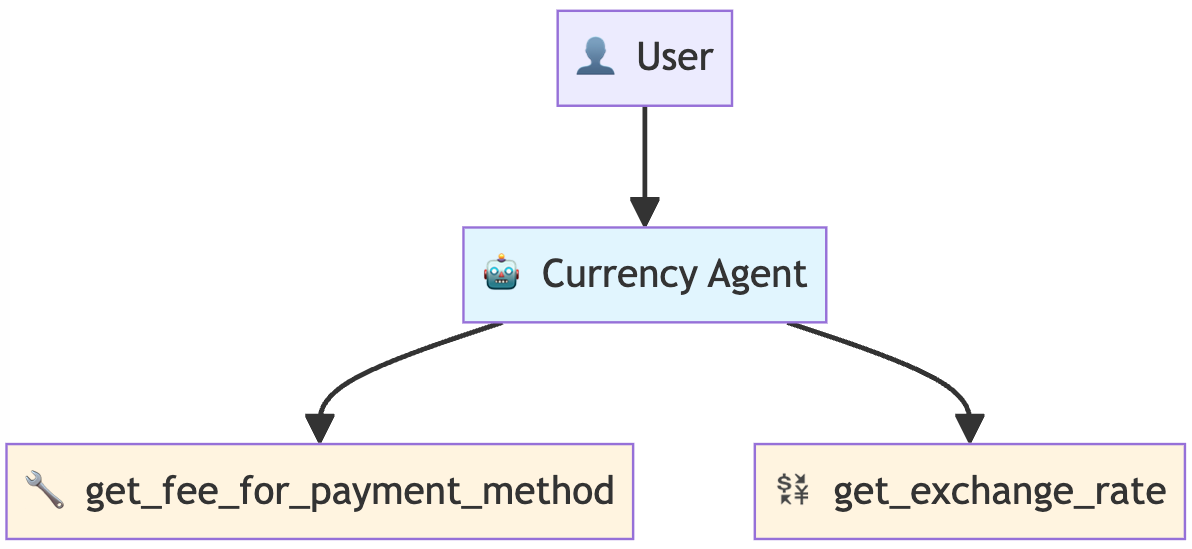
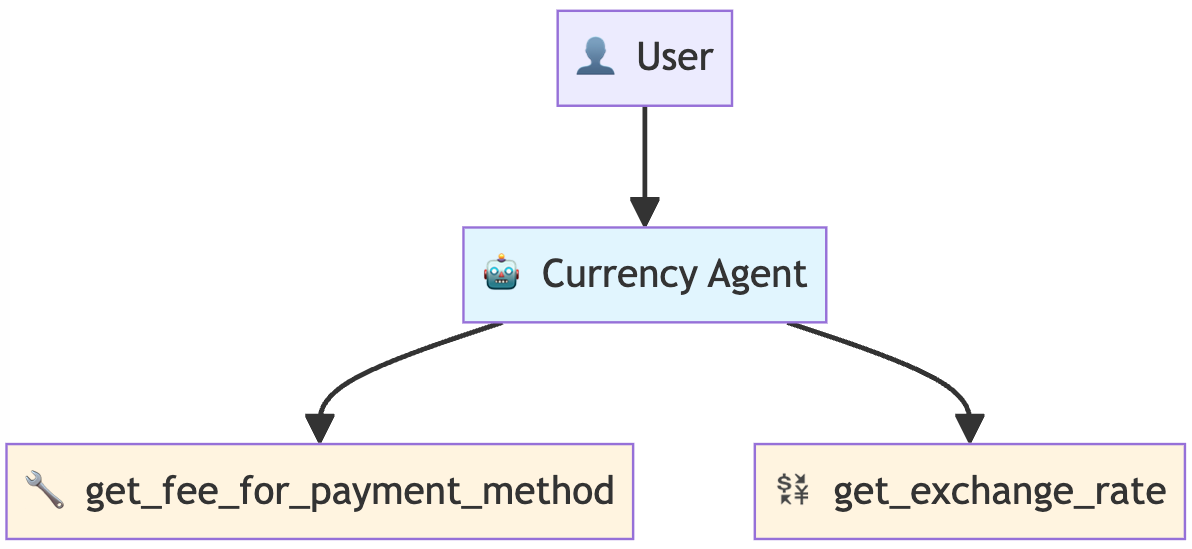

In [11]:
# Pay attention to the docstring, type hints, and return value ..
def get_fee_for_payment_method(method : str) -> dict:
    """Looks up the transaction fee percentage for a given payment method.

    This tool simulates looking up a company's internal fee structure based on
    the name of the payment method provided by the user.

    Args:
        method: The name of the payment method. It should be descriptive,
                e.g., "platinum credit card" or "bank transfer".

    Returns:
        Dictionary with status and fee information.
        Success : {"status": "success", "fee_percentage": 0.02}
        Error : {"status": "error", "error_message": "Payment method not found"}
    """
    # This simulates looking up a company's internal fee structure ..
    fee_database = {
        "platinum credit card" : 0.02,  # 2%
        "gold debit card" : 0.035,  # 3.5%
        "bank transfer" : 0.01,  # 1%
    }

    fee = fee_database.get(method.lower())
    if fee is not None:
        return {"status" : "success", "fee_percentage" : fee}
    else:
        return {
            "status" : "error",
            "error_message" : f"Payment method '{method}' not found",
        }


print(f"{B}{Green}Fee lookup function created.{R}")
print(f"{Red}Test: {B}{get_fee_for_payment_method('platinum credit card')}{R}")

Fee lookup function created.
Test: {'status': 'success', 'fee_percentage': 0.02}


Let's follow the same best practices to define our second tool `get_exchange_rate`.

In [12]:
def get_exchange_rate(base_currency : str, target_currency : str) -> dict:
    """Looks up and returns the exchange rate between two currencies.

    Args:
        base_currency: The ISO 4217 currency code of the currency you
                       are converting from (e.g., "USD").
        target_currency: The ISO 4217 currency code of the currency you
                         are converting to (e.g., "EUR").

    Returns:
        Dictionary with status and rate information.
        Success: {"status": "success", "rate": 0.93}
        Error: {"status": "error", "error_message": "Unsupported currency pair"}
    """

    # Static data simulating a live exchange rate API ..
    # In production, this would call something like: requests.get("api.exchangerates.com") ..
    rate_database = {
        "usd": {
            "eur": 0.93,  # Euro ..
            "jpy": 157.50,  # Japanese Yen ..
            "inr": 83.58,  # Indian Rupee ..
        }
    }

    # Input validation and processing ..
    base = base_currency.lower()
    target = target_currency.lower()

    # Return structured result with status ..
    rate = rate_database.get(base, {}).get(target)
    if rate is not None:
        return {"status" : "success", "rate" : rate}
    else:
        return {
            "status" : "error",
            "error_message" : f"Unsupported currency pair: {base_currency}/{target_currency}",
        }


print(f"{B}{Green}Exchange rate function created.{R}")
print(f"{Red}Test: {B}{get_exchange_rate('USD', 'EUR')}{R}")

Exchange rate function created.
Test: {'status': 'success', 'rate': 0.93}


Now let's create our currency agent. Pay attention to how the agent's instructions reference the tools:

Key Points:

 - The `tools=[]` list tells the agent which functions it can use
 - Instructions reference tools by their exact function names (e.g., `get_fee_for_payment_method()`)
 - The agent uses these names to decide when and how to call each tool

In [14]:
# Currency agent with custom function tools ..
currency_agent = LlmAgent(
    name = "currency_agent",
    model = Gemini(model="gemini-2.5-flash-lite", retry_options=retry_config),
    instruction = """You are a smart currency conversion assistant.

    For currency conversion requests:
    1. Use `get_fee_for_payment_method()` to find transaction fees
    2. Use `get_exchange_rate()` to get currency conversion rates
    3. Check the "status" field in each tool's response for errors
    4. Calculate the final amount after fees based on the output from `get_fee_for_payment_method` and `get_exchange_rate` methods and provide a clear breakdown.
    5. First, state the final converted amount.
        Then, explain how you got that result by showing the intermediate amounts. Your explanation must include: the fee percentage and its
        value in the original currency, the amount remaining after the fee, and the exchange rate used for the final conversion.

    If any tool returns status "error", explain the issue to the user clearly.
    """,
    tools = [get_fee_for_payment_method, get_exchange_rate],
)


print("Currency agent created with custom function tools")
print("Available tools:")
print(f"  • {B}get_fee_for_payment_method{R} - Looks up company fee structure")
print(f"  • {B}get_exchange_rate{R} - Gets current exchange rates")

Currency agent created with custom function tools
Available tools:
  • get_fee_for_payment_method - Looks up company fee structure
  • get_exchange_rate - Gets current exchange rates


In [ ]:
# Test the currency agent ..
currency_runner = InMemoryRunner(agent = currency_agent)
_ = await currency_runner.run_debug(
    "I want to convert 500 US Dollars to Euros using my Platinum Credit Card. How much will I receive?"
)

### Improving Agent Reliability with Code
The agent's instruction says "*calculate the final amount after fees*" but LLMs aren't always reliable at math. They might make calculation errors or use inconsistent formulas.

***Solution: Let's ask our agent to generate a Python code to do the math, and run it to give us the final result! Code execution is much more reliable than having the LLM try to do math in its head!***
### Built-in Code Executor
ADK has a built-in Code Executor capable of running code in a sandbox. Note: This uses Gemini's Code Execution capability.

Let's create a `calculation_agent` which takes in a Python code and uses the `BuiltInCodeExecutor` to run it.
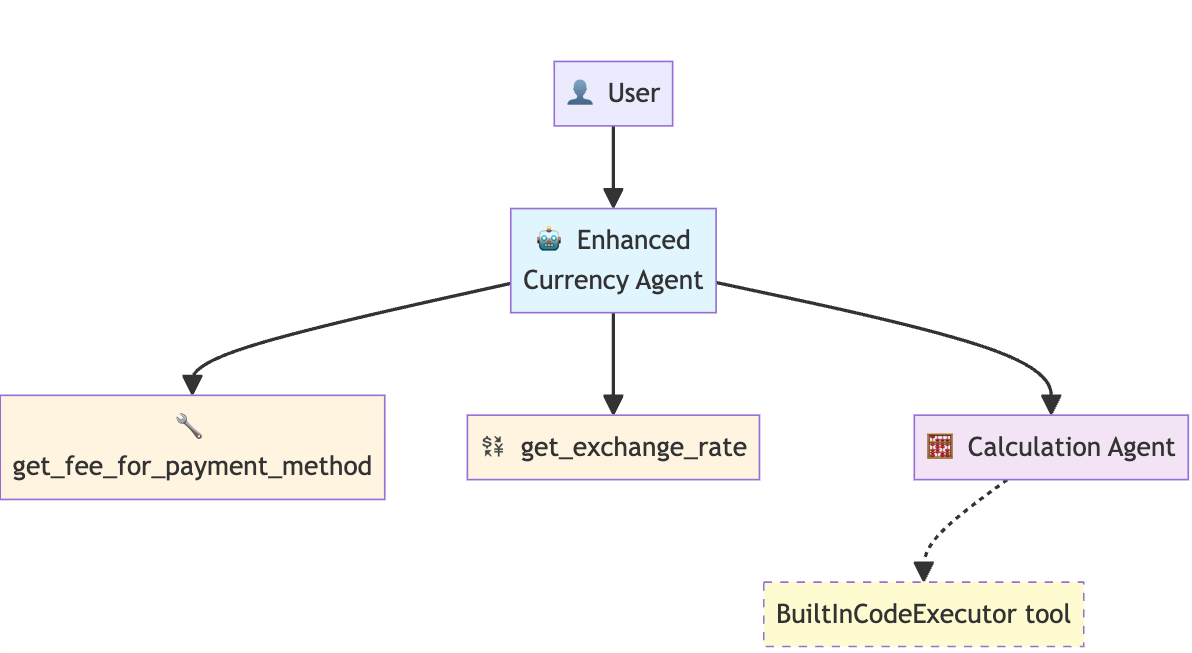
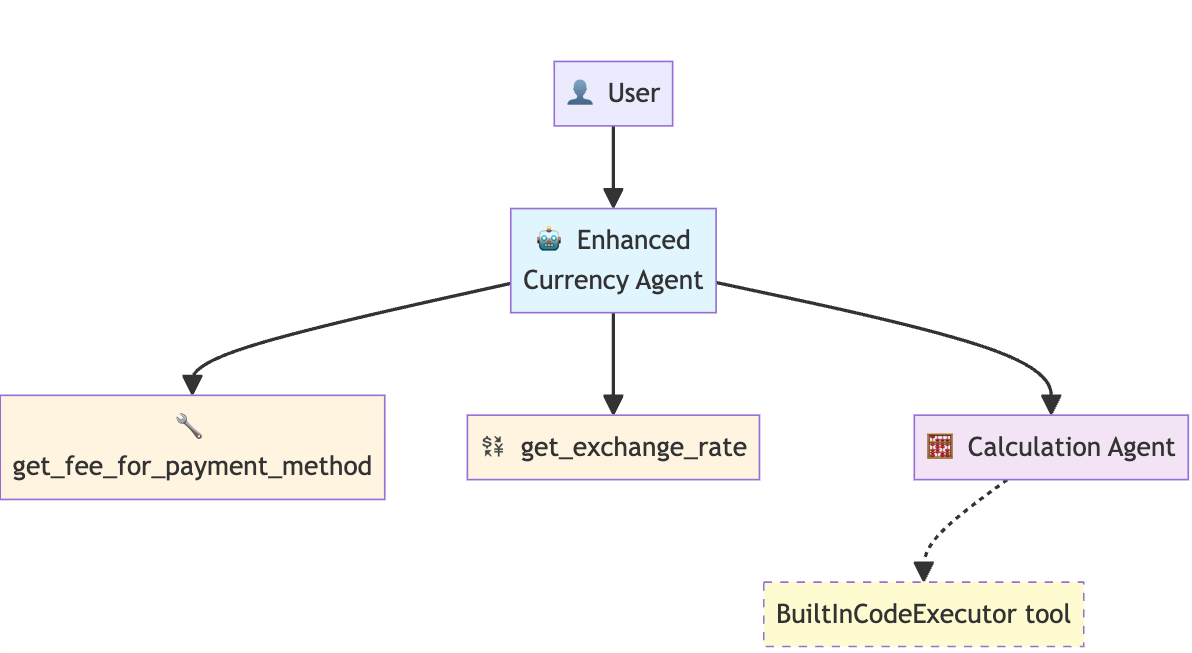

In [16]:
calculation_agent = LlmAgent(
    name = "CalculationAgent",
    model = Gemini(
        model = "gemini-2.5-flash-lite",
        retry_options = retry_config
    ),
    instruction = """You are a specialized calculator that ONLY responds with Python code. You are forbidden from providing any text, explanations, or conversational responses.
 
     Your task is to take a request for a calculation and translate it into a single block of Python code that calculates the answer.
     
     **RULES:**
    1.  Your output MUST be ONLY a Python code block.
    2.  Do NOT write any text before or after the code block.
    3.  The Python code MUST calculate the result.
    4.  The Python code MUST print the final result to stdout.
    5.  You are PROHIBITED from performing the calculation yourself. Your only job is to generate the code that will perform the calculation.
   
    Failure to follow these rules will result in an error.
       """,
    code_executor = BuiltInCodeExecutor(),  # Use the built-in Code Executor Tool. This gives the agent code execution capabilities ..
)

#### Update the Agent's instruction and toolset
We'll do two key actions:

 1. Update the `currency_agent`'s instructions to generate Python code
 - *Original*: "Calculate the final amount after fees" (vague math instructions)
 - *Enhanced*: "Generate a Python code to calculate the final amount .. and use the `calculation_agent` to run the code and compute final amount"

 2. Add the `calculation_agent` to the toolset

 - ADK lets you use any agent as a tool using `AgentTool`.
 - Add `AgentTool(agent=calculation_agent)` to the tools list
 - The specialist agent appears as a callable tool to the root agent

Let's see this in action:

In [18]:
enhanced_currency_agent = LlmAgent(
    name = "enhanced_currency_agent",
    model = Gemini(
        model = "gemini-2.5-flash-lite",
        retry_options=retry_config
    ),
    # Updated instruction ..
    instruction = """You are a smart currency conversion assistant. You must strictly follow these steps and use the available tools.

  For any currency conversion request:

   1. Get Transaction Fee: Use the get_fee_for_payment_method() tool to determine the transaction fee.
   2. Get Exchange Rate: Use the get_exchange_rate() tool to get the currency conversion rate.
   3. Error Check: After each tool call, you must check the "status" field in the response. If the status is "error", you must stop and clearly explain the issue to the user.
   4. Calculate Final Amount (CRITICAL): You are strictly prohibited from performing any arithmetic calculations yourself. You must use the calculation_agent tool to generate Python code that calculates the final converted amount. This 
      code will use the fee information from step 1 and the exchange rate from step 2.
   5. Provide Detailed Breakdown: In your summary, you must:
       * State the final converted amount.
       * Explain how the result was calculated, including:
           * The fee percentage and the fee amount in the original currency.
           * The amount remaining after deducting the fee.
           * The exchange rate applied.
    """,
    tools = [
        get_fee_for_payment_method,
        get_exchange_rate,
        AgentTool(agent = calculation_agent),  # Using another agent as a tool!
    ],
)

print(f"{Green}{B}Enhanced currency agent created.{R}")
print(f"New capability: {B}Delegates calculations to specialist agent.{R}")
print("Tool types used:")
print(f"  • {B}Function Tools{R} (fees, rates)")
print(f"  • {B}Agent Tool{R} (calculation specialist)")

Enhanced currency agent created.
New capability: Delegates calculations to specialist agent.
Tool types used:
  • Function Tools (fees, rates)
  • Agent Tool (calculation specialist)


In [19]:
# Define a runner ..
enhanced_runner = InMemoryRunner(agent=enhanced_currency_agent)

In [ ]:
# Test the enhanced agent ..
response = await enhanced_runner.run_debug(
    "Convert 1,250 USD to INR using a Bank Transfer. Show me the precise calculation."
)

---
What happened:

 - When the Currency agent calls the `CalculationAgent`, it passes in the generated Python code
 - The `CalculationAgent` in turn used the `BuiltInCodeExecutor` to run the code and gave us precise calculations instead of LLM guesswork!

Now we can inspect the parts of the response that either generated Python code or that contain the Python code results, using the helper function that was defined near the beginning of this notebook:

In [ ]:
show_python_code_and_result(response)

### Agent Tools vs Sub-Agents: What's the Difference?
This is a common question! Both involve using multiple agents, but they work very differently:

**Agent Tools (what we're using):**

 - Agent A calls Agent B as a tool
 - Agent B's response goes back to Agent A
 - Agent A stays in control and continues the conversation
 - Use case: Delegation for specific tasks (like calculations)

**Sub-Agents (different pattern):**

 - Agent A transfers control completely to Agent B
 - Agent B takes over and handles all future user input
 - Agent A is out of the loop
 - Use case: Handoff to specialists (like customer support tiers)

In our currency example: We want the currency agent to get calculation results and continue working with them, so we use Agent Tools, not sub-agents.

### Complete Guide to ADK Tool Types
Now that we've seen tools in action, let's understand the complete ADK toolkit:

It's broadly divided into two categories: Custom tools and Built-in tools

1. Custom Tools

 - What: Tools you build yourself for specific needs
 - Advantage: Complete control over functionality — you build exactly what your agent needs

**Function Tools** (We've used these!)

 - What: Python functions converted to agent tools
 - Examples: get_fee_for_payment_method, get_exchange_rate
 - Advantage: Turn any Python function into an agent tool instantly

**Long Running Function Tools**

 - What: Functions for operations that take significant time
 - Examples: Human-in-the-loop approvals, file processing
 - Advantage: Agents can start tasks and continue with other work 
while waiting

**Agent Tools** (We've used these!)

 - What: Other agents used as tools
 - Examples: AgentTool(agent=calculation_agent)
 - Advantage: Build specialist agents and reuse them across 
different systems

**MCP Tools**

 - What: Tools from Model Context Protocol servers
 - Examples: Filesystem access, Google Maps, databases
 - Advantage: Connect to any MCP-compatible service without custom 
integration

**OpenAPI Tools**

 - What: Tools automatically generated from API specifications
 - Examples: REST API endpoints become callable tools
 - Advantage: No manual coding — just provide an API spec and get 
working tools

2. Built-in Tools

 - What: Pre-built tools provided by ADK
 - Advantage: No development time — use immediately with zero setup

**Gemini Tools** (We've used these!)

 - What: Tools that leverage Gemini's capabilities
 - Examples: google_search, BuiltInCodeExecutor
 - Advantage: Reliable, tested tools that work out of the box

**Google Cloud Tools**

 - What: Tools for Google Cloud services and enterprise integration
 - Examples: BigQueryToolset, SpannerToolset, APIHubToolset
 - Advantage: Enterprise-grade database and API access with built-in 
security

**Third-party Tools**

 - What: Wrappers for existing tool ecosystems
 - Examples: Hugging Face, Firecrawl, GitHub Tools
 - Advantage: Reuse existing tool investments — no need to rebuild 
what already exists
